# Task 3.2: Anomaly Detection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import itertools
from collections import OrderedDict
from helper import *

### Load data

In [54]:
X_train, y_train = load_dataset("../data/training2_with_incidents.csv")
X_test, y_test        = load_dataset("../data/training2_with_incidents.csv") # TODO: for testing purposes only!

### Define sensors to consider

In [55]:
features = ['L_T1','L_T2','L_T3','L_T4','L_T5','L_T6','L_T7',
            'F_PU1','S_PU1','F_PU2','S_PU2','F_PU3','S_PU3','F_PU4','S_PU4','F_PU5','S_PU5','F_PU6','S_PU6','F_PU7','S_PU7','F_PU8','S_PU8','F_PU9','S_PU9','F_PU10','S_PU10','F_PU11','S_PU11',
            'F_V2','S_V2',
            'P_J280','P_J269','P_J300','P_J256','P_J289','P_J415','P_J302','P_J306','P_J307','P_J317','P_J14','P_J422']

### Optimize parameters on training set

In [56]:
# Grid search parameters
paa_window_size = range(3,10)
sax_alphab_size = range(3,6)
ngram_length = [3]
thresholds = [.001, .002, 0.003, .01]

grid = list(itertools.product(paa_window_size, sax_alphab_size, ngram_length, thresholds))
grid_search_results = {}

In [57]:
%%time

# Detect anomalies for every configuration in grid
for conf in grid:
    
    predictions = detect(X_train[features], *conf)
    
    # Score (returns precision, recall and f1-score)
    grid_search_results[conf] = score(y_train[:len(predictions)], predictions)

print("Done")

KeyboardInterrupt: 

#### Evaluate grid search results

In [58]:
best = False

print('='*54)
print(' {:5s} {:5s} {:5s} {:7s}  |  {:7} {:7} {:7}'.format('PAA', 'SAX', 'n-Gr', 'Thres.', 'Prec.', 'Recall', 'F1'))
print('='*54)

# Sort grid search results on F1-score and display top 25 options
for conf in sorted(grid_search_results, key=lambda x: grid_search_results[x][0], reverse=True)[:25]:
    if not best: best = conf
    print(' {:<5d} {:<5d} {:<5d} {:<7.4f}  |  {:<7.4f} {:<7.4f} {:<7.4f}'.format(*conf, *grid_search_results[conf]))


 PAA   SAX   n-Gr  Thres.   |  Prec.   Recall  F1     
 3     3     3     0.0010   |  0.0000  0.0000  0.0000 
 3     3     3     0.0020   |  0.0000  0.0000  0.0000 
 3     3     3     0.0030   |  0.0000  0.0000  0.0000 
 3     3     3     0.0100   |  0.0000  0.0000  0.0000 
 3     4     3     0.0010   |  0.0000  0.0000  0.0000 
 3     4     3     0.0020   |  0.0000  0.0000  0.0000 
 3     4     3     0.0030   |  0.0000  0.0000  0.0000 
 3     4     3     0.0100   |  0.0000  0.0000  0.0000 
 3     5     3     0.0010   |  0.0000  0.0000  0.0000 
 3     5     3     0.0020   |  0.0000  0.0000  0.0000 
 3     5     3     0.0030   |  0.0000  0.0000  0.0000 
 3     5     3     0.0100   |  0.0000  0.0000  0.0000 
 4     3     3     0.0010   |  0.0000  0.0000  0.0000 
 4     3     3     0.0020   |  0.0000  0.0000  0.0000 
 4     3     3     0.0030   |  0.0000  0.0000  0.0000 
 4     3     3     0.0100   |  0.0000  0.0000  0.0000 
 4     4     3     0.0010   |  0.0000  0.0000  0.0000 
 4     4  

### Evaluate performance on test set

In [62]:
# Unpack best parameters
# paa, sax, ngram, threshold = best
paa = 8
sax = 3
ngram = 3
threshold = 0.0015

# Init predictions vector
predictions = [0] * (len(X_test) - len(X_test) % paa)

for sensor in features:

    # Discretize test data
    X_test_discr, _ = discretize_series(X_test[sensor], n_sax_symbols=sax, hours_in_segment=paa)
    X_test_discr = X_test_discr[0].ravel()
    
    # Detect anomalies
    proba = ngram_proba_series(X_test_discr, n=ngram)
    labels = find_anomalies(X_test_discr, proba, n=ngram, threshold=threshold, window_size=paa)
    
    # Add anomalies to overall predictions
    predictions = np.add(predictions, labels)
    
# Reset incidents which have been predicted by multiple sensors
predictions[predictions > 1] = 1

display(np.sum(predictions))

# Score (returns precision, recall and f1-score)
score(y_test[:len(predictions)], predictions)

0

(0, 0, 0)

### Visualize detected attacks

In [46]:
p = pd.Series(predictions, index=X_test.index[:len(predictions)])

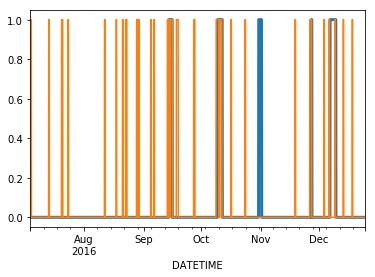

In [63]:
y_test.plot.line(linewidth=3)
p.plot.line()

# TODO

 - Sequence alignment + distance calculation? (weet niet of dat kan als datasets niet dezelfde lengte heeft)